D1 ロジスティック回帰
57994 139667
18519 115332
acc 52.28 pre 45.23 rec 86.16 f1  59.32

D2　正規化/標準化　SVM　ホールドアウト/クロスバリデーション　正則化

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC

In [3]:
#csvファイル読込。
df = pd.read_csv("./ks-projects-201801.csv")
#df

In [4]:
#データ数。
display(df.count())
display(df.shape)


ID                  378661
name                378657
category            378661
main_category       378661
currency            378661
deadline            378661
goal                378661
launched            378661
pledged             378661
state               378661
backers             378661
country             378661
usd pledged         374864
usd_pledged_real    378661
usd_goal_real       378661
dtype: int64

(378661, 15)

In [5]:
#欠損値の確認。
display(df.isnull().sum())

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [6]:
#ID name category main_category currency deadline goal launched pledged
#state backers country usd pledged usd_pledged_real usd_goal_real
#説明変数
#使えそう
#main_category, deadline(締切),
#launched(開始日), country, usd_goal_real(目標額USD？)
#main_categoryとusd_goalはセットで使えそう。(高価くても人気のジャンルとか、高価いといらないジャンルとか。)単体だと？
#deadlineとlaunchedはそのままじゃなくて期間にしたほうが都合よさそう。時間？日にち？
#countryは国によって成功率違うとかあるなら使えるか？

#nameを格上げ。名前→使用言語<無理、ワード数、使用ワード、内容<無理、 

#使えなさそう
#ID, pledged(支援額), backers(支援者数), usd pledged(支援額USD), usd_pledged_real

#category, currency(通貨),  goal(目標額) を格下げ
#(main_category > category、countryとcurrncyはほぼ等価、USD/currency * goal =usd_goal_real)

#目的変数
#state

In [7]:
#Stateの確認。
df['state'].value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

In [8]:
#使うのはsuccesfullとfailedだけ？canceled,suspendedも失敗扱いか？>数が少ないから無視。
#canceled　中断
#undefined　未定義
#live　生きてる、まだ実行中？
#suspended　中断
df_success = (df[df['state']=='successful'])
df_failed =  (df[df['state']=='failed'])
df_canceled =  (df[df['state']=='canceled'])
df_suspended =  (df[df['state']=='suspended'])
df_live =  (df[df['state']=='live'])

df_state = pd.concat([df_success,df_failed])
df_state

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.00,successful,224,US,52375.00,52375.00,50000.00
6,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21,1000.0,2014-12-01 18:30:44,1205.00,successful,16,US,1205.00,1205.00,1000.00
11,100005484,Lisa Lim New CD!,Indie Rock,Music,USD,2013-04-08,12500.0,2013-03-09 06:42:58,12700.00,successful,100,US,12700.00,12700.00,12500.00
14,1000057089,Tombstone: Old West tabletop game and miniatur...,Tabletop Games,Games,GBP,2017-05-03,5000.0,2017-04-05 19:44:18,94175.00,successful,761,GB,57763.78,121857.33,6469.73
18,1000070642,Mike Corey's Darkness & Light Album,Music,Music,USD,2012-08-17,250.0,2012-08-02 14:11:32,250.00,successful,7,US,250.00,250.00,250.00
20,1000072011,CMUK. Shoes: Take on Life Feet First.,Fashion,Fashion,USD,2013-12-30,20000.0,2013-11-25 07:06:11,34268.00,successful,624,US,34268.00,34268.00,20000.00
24,1000091520,The Book Zoo - A Mini-Comic,Comics,Comics,USD,2014-11-12,175.0,2014-10-23 17:15:50,701.66,successful,66,US,701.66,701.66,175.00
25,1000102741,Matt Cavenaugh & Jenny Powers make their 1st a...,Music,Music,USD,2011-01-06,10000.0,2010-12-07 23:16:50,15827.00,successful,147,US,15827.00,15827.00,10000.00
27,1000104688,Permaculture Skills,Webseries,Film & Video,CAD,2014-12-14,17757.0,2014-11-14 18:02:00,48905.00,successful,571,CA,43203.25,42174.03,15313.04
28,1000104953,Rebel Army Origins: The Heroic Story Of Major ...,Comics,Comics,GBP,2016-01-28,100.0,2015-12-29 16:59:29,112.38,successful,27,GB,167.70,160.60,142.91


failed        197719
successful    133956
Name: state, dtype: int64

([<matplotlib.patches.Wedge at 0x18d00bfdd68>,
 [Text(-0.327151,1.05022,'failed'), Text(0.32715,-1.05023,'successful')])

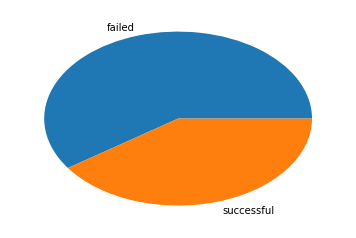

In [9]:
#Stateの割合。
display(df_state['state'].value_counts())
display(plt.pie(df_state['state'].value_counts(), labels=df_state['state'].value_counts().keys()))


([<matplotlib.patches.Wedge at 0x1f14b158160>,
 [Text(1.08283,0.193615,'Product Design'),
  Text(0.969825,0.519076,'Documentary'),
  Text(0.80587,0.748715,'Music'),
  Text(0.613139,0.913269,'Tabletop Games'),
  Text(0.399919,1.02473,'Shorts'),
  Text(0.181228,1.08497,'Food'),
  Text(-0.0236547,1.09975,'Video Games'),
  Text(-0.209414,1.07988,'Film & Video'),
  Text(-0.377218,1.0333,'Fiction'),
  Text(-0.525573,0.966319,'Fashion'),
  Text(-0.657234,0.882067,'Art'),
  Text(-0.774774,0.780849,'Nonfiction'),
  Text(-0.871838,0.670745,'Theater'),
  Text(-0.94725,0.559212,'Rock'),
  Text(-1.00644,0.44394,"Children's Books"),
  Text(-1.05142,0.323304,'Apparel'),
  Text(-1.08109,0.203074,'Technology'),
  Text(-1.0964,0.0889651,'Indie Rock'),
  Text(-1.09979,-0.0215453,'Apps'),
  Text(-1.09217,-0.130979,'Photography'),
  Text(-1.07401,-0.237697,'Webseries'),
  Text(-1.04607,-0.340191,'Publishing'),
  Text(-1.01057,-0.434445,'Narrative Film'),
  Text(-0.968933,-0.520738,'Comics'),
  Text(-0.9217

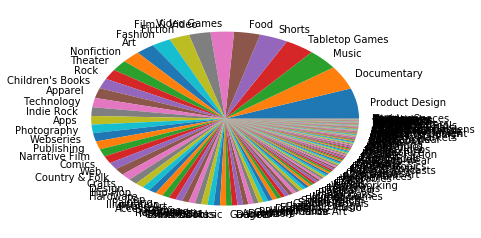

In [9]:
#Categoryの割合。細分化しすぎ。10件しかないのとかある。
#display(df_state['category'].value_counts())
display(plt.pie(df_state['category'].value_counts(), labels=df_state['category'].value_counts().keys()))


([<matplotlib.patches.Wedge at 0x1f14f0547f0>,
 [Text(0.946061,0.561221,'Film & Video'),
  Text(0.0711595,1.0977,'Music'),
  Text(-0.713859,0.836902,'Publishing'),
  Text(-1.0634,0.281403,'Games'),
  Text(-1.06083,-0.29093,'Technology'),
  Text(-0.792186,-0.763178,'Art'),
  Text(-0.346996,-1.04384,'Design'),
  Text(0.140642,-1.09097,'Food'),
  Text(0.55077,-0.952183,'Fashion'),
  Text(0.795748,-0.759463,'Theater'),
  Text(0.925202,-0.594981,'Comics'),
  Text(1.019,-0.414297,'Photography'),
  Text(1.07341,-0.240413,'Crafts'),
  Text(1.09371,-0.117459,'Journalism'),
  Text(1.09937,-0.0372203,'Dance')])

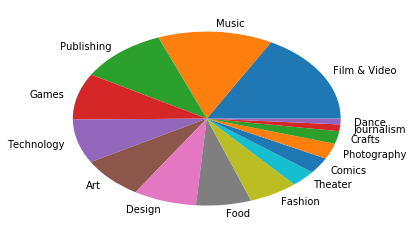

In [10]:
#main_Categoryの割合。
#display(df_state['main_category'].value_counts())
display(plt.pie(df_state['main_category'].value_counts(), labels=df_state['main_category'].value_counts().keys()))


([<matplotlib.patches.Wedge at 0x1f14f379198>,
 [Text(-0.865889,0.678407,'USD'),
  Text(0.547348,-0.954154,'GBP'),
  Text(0.885841,-0.65214,'EUR'),
  Text(1.02104,-0.409235,'CAD'),
  Text(1.0778,-0.219904,'AUD'),
  Text(1.09152,-0.136326,'SEK'),
  Text(1.09487,-0.106078,'MXN'),
  Text(1.09722,-0.0782023,'NZD'),
  Text(1.09861,-0.0552918,'DKK'),
  Text(1.09931,-0.0388344,'CHF'),
  Text(1.09969,-0.0259621,'NOK'),
  Text(1.0999,-0.0149094,'HKD'),
  Text(1.09999,-0.00520966,'SGD'),
  Text(1.1,-0.000239777,'JPY')])

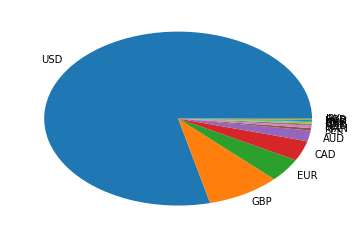

In [11]:
#currencyの割合。
plt.pie(df_state['currency'].value_counts(), labels=df_state['currency'].value_counts().keys())


C:\Users\M\AppData\Roaming\Python\Python36\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


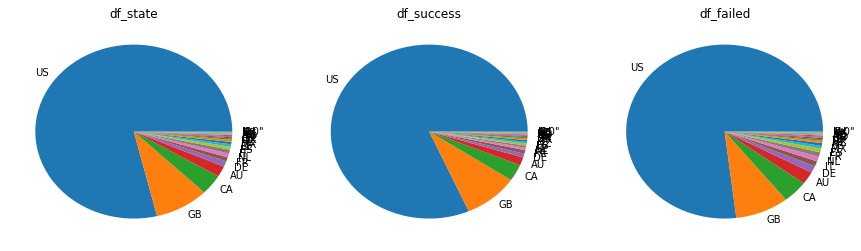

In [12]:
#countryの割合。
fig, (L, C, R) = plt.subplots(ncols=3, figsize=(15,4))
#
L.pie(df_state['country'].value_counts(), labels=df_state['country'].value_counts().keys())
L.set_title('df_state')

C.pie(df_success['country'].value_counts(), labels=df_success['country'].value_counts().keys())
C.set_title('df_success')

R.pie(df_failed['country'].value_counts(), labels=df_failed['country'].value_counts().keys())
R.set_title('df_failed')

fig.show()

In [13]:
#使えそうな項目だけコピー。
df_sel = df_state.loc[:,['state','name','category','main_category','currency','deadline','goal','launched','country', 'usd_goal_real']]
df_sel

,state,name,category,main_category,currency,deadline,goal,launched,country,usd_goal_real
5,successful,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,US,50000.00
6,successful,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21,1000.0,2014-12-01 18:30:44,US,1000.00
11,successful,Lisa Lim New CD!,Indie Rock,Music,USD,2013-04-08,12500.0,2013-03-09 06:42:58,US,12500.00
14,successful,Tombstone: Old West tabletop game and miniatur...,Tabletop Games,Games,GBP,2017-05-03,5000.0,2017-04-05 19:44:18,GB,6469.73
18,successful,Mike Corey's Darkness & Light Album,Music,Music,USD,2012-08-17,250.0,2012-08-02 14:11:32,US,250.00
20,successful,CMUK. Shoes: Take on Life Feet First.,Fashion,Fashion,USD,2013-12-30,20000.0,2013-11-25 07:06:11,US,20000.00
24,successful,The Book Zoo - A Mini-Comic,Comics,Comics,USD,2014-11-12,175.0,2014-10-23 17:15:50,US,175.00
25,successful,Matt Cavenaugh & Jenny Powers make their 1st a...,Music,Music,USD,2011-01-06,10000.0,2010-12-07 23:16:50,US,10000.00
27,successful,Permaculture Skills,Webseries,Film & Video,CAD,2014-12-14,17757.0,2014-11-14 18:02:00,CA,15313.04
28,successful,Rebel Army Origins: The Heroic Story Of Major ...,Comics,Comics,GBP,2016-01-28,100.0,2015-12-29 16:59:29,GB,142.91


In [14]:
#欠損値の確認。
display(df_sel.isnull().sum())

state            0
name             3
category         0
main_category    0
currency         0
deadline         0
goal             0
launched         0
country          0
usd_goal_real    0
dtype: int64

In [15]:
#欠損値のある行は削除。
df_sel = df_sel.dropna(how='any')
display(df_sel.isnull().sum())

state            0
name             0
category         0
main_category    0
currency         0
deadline         0
goal             0
launched         0
country          0
usd_goal_real    0
dtype: int64

In [16]:
#LabelEncoderで変換。->state以外は値に意味が乗ってしまうと都合が悪い
le = LabelEncoder()
le = le.fit(df_sel['state'])
df_sel['state'] = le.transform(df_sel['state'])

#deadline - launchedで期間(日数)。
df_sel['time_dif'] = (pd.to_datetime(df_sel['deadline']) - pd.to_datetime(df_sel['launched'])).dt.days
df_sel = df_sel.drop('deadline',axis=1)
df_sel = df_sel.drop('launched',axis=1)

#時間かかるのでデータをランダムに抽出
df_rand_sel = df_sel.sample(n=10000,random_state=1234)

display(df_rand_sel)

C:\Users\M\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\M\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,state,name,category,main_category,currency,goal,country,usd_goal_real,time_dif
328171,0,"GPS Tracking for your pet, and it's SOLAR powe...",Hardware,Technology,USD,70000.0,US,70000.00,38
93840,0,Put the Tide on TOUR!!!,World Music,Music,USD,1000.0,US,1000.00,58
37560,0,Orchard- Glen Ard Mohr Estate Tasmania,Farms,Food,AUD,25000.0,AU,18673.44,19
39629,0,Static Prevails Us Album Indie Rock,Indie Rock,Music,USD,2000.0,US,2000.00,29
302398,1,MSGEQ7 breakout boards,Sound,Technology,USD,1000.0,US,1000.00,49
107431,0,"Custom Leather Pyrography Work (Hats, Saddles,...",Accessories,Fashion,USD,25000.0,US,25000.00,35
83217,0,VidaPak Single Serve Hot and Cold Beverage Mak...,Technology,Technology,USD,95000.0,US,95000.00,44
322320,1,The SuzieQ Doll,Product Design,Design,CAD,12000.0,CA,9446.59,39
290932,1,Earn The Season,Shorts,Film & Video,USD,10000.0,US,10000.00,19
99055,1,THE TOUGHEST GIRL ALIVE! The Life & Times of C...,Theater,Theater,USD,6000.0,US,6000.00,44


In [17]:
#
#その1＿Day1の修正
#ロジスティック回帰をそのまま使う
#
#nameをWords_Countに分割する
#usdgoal,timediffを標準化する
#'main_category', 'category', 'currency', 'country'はどうする？増えすぎた。
#＞とりあえずcategoryとcurrencyは削除しとく goal

In [18]:

#df_dum = pd.get_dummies(df_sel,columns=['main_category', 'category', 'currency', 'country'])
df_dum = pd.get_dummies(df_rand_sel,columns=['main_category', 'country'])
df_dum = df_dum.drop('category',axis=1)
df_dum = df_dum.drop('currency',axis=1)
df_dum = df_dum.drop('goal',axis=1)

display(df_dum)
display(df_dum.shape)

,state,name,usd_goal_real,time_dif,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,...,country_IT,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
328171,0,"GPS Tracking for your pet, and it's SOLAR powe...",70000.00,38,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
93840,0,Put the Tide on TOUR!!!,1000.00,58,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
37560,0,Orchard- Glen Ard Mohr Estate Tasmania,18673.44,19,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39629,0,Static Prevails Us Album Indie Rock,2000.00,29,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
302398,1,MSGEQ7 breakout boards,1000.00,49,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
107431,0,"Custom Leather Pyrography Work (Hats, Saddles,...",25000.00,35,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
83217,0,VidaPak Single Serve Hot and Cold Beverage Mak...,95000.00,44,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
322320,1,The SuzieQ Doll,9446.59,39,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
290932,1,Earn The Season,10000.00,19,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
99055,1,THE TOUGHEST GIRL ALIVE! The Life & Times of C...,6000.00,44,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


(10000, 41)

In [19]:
#単語数を数える。スペースかタブか改行で区切る
def Count_Words(s):
    if type(s) is str:
        words = s.split()
        return len(words)
    else:
        return 0
#単語数の行を追加
df_dum["words_count"] = df_dum.name.apply(Count_Words)
#出てくる単語も取りたいけど。。。


df_dum = df_dum.drop('name',axis=1)
df_dum

,state,usd_goal_real,time_dif,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,...,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US,words_count
328171,0,70000.00,38,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,10
93840,0,1000.00,58,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,5
37560,0,18673.44,19,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
39629,0,2000.00,29,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,6
302398,1,1000.00,49,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3
107431,0,25000.00,35,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,8
83217,0,95000.00,44,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,10
322320,1,9446.59,39,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,3
290932,1,10000.00,19,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,3
99055,1,6000.00,44,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,11


In [20]:
#値の標準化
#ここでその2に分岐
df1 = df_dum
df_temp =  df1.loc[:,['usd_goal_real', 'time_dif']]

std_scaler = preprocessing.StandardScaler()
std_scaler.fit(df_temp)
df_std = pd.DataFrame(std_scaler.transform(df_temp),columns=df_temp.columns)

display(df1.shape)
display(df_std.shape)
df_std

(10000, 41)

(10000, 2)

,usd_goal_real,time_dif
0,0.018047,0.397941
1,-0.030482,1.983742
2,-0.018052,-1.108570
3,-0.029779,-0.315670
4,-0.030482,1.270131
5,-0.013602,0.160071
6,0.035629,0.873681
7,-0.024541,0.477231
8,-0.024152,-1.108570
9,-0.026965,0.873681


In [21]:
#なぜか結合時に項目数(行数)が増えてる
#削除した行のindexが歯抜けになってたので振りなおし
df1=df1.drop(['usd_goal_real', 'time_dif'],axis=1)
df1_r = df1.reset_index(drop=True)
display(df1_r)

,state,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,...,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US,words_count
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,10
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,5
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,6
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,6
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3
5,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,8
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,10
7,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
8,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,3
9,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,11


In [22]:
df_std_r = df_std.reset_index(drop=True)
display(df_std_r)

,usd_goal_real,time_dif
0,0.018047,0.397941
1,-0.030482,1.983742
2,-0.018052,-1.108570
3,-0.029779,-0.315670
4,-0.030482,1.270131
5,-0.013602,0.160071
6,0.035629,0.873681
7,-0.024541,0.477231
8,-0.024152,-1.108570
9,-0.026965,0.873681


In [23]:
df_std = pd.concat([df1_r,df_std_r],axis=1)

display(df_std.shape)
df_std

(10000, 41)

,state,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,...,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US,words_count,usd_goal_real,time_dif
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,10,0.018047,0.397941
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,5,-0.030482,1.983742
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,6,-0.018052,-1.108570
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,6,-0.029779,-0.315670
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,3,-0.030482,1.270131
5,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,8,-0.013602,0.160071
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,10,0.035629,0.873681
7,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,3,-0.024541,0.477231
8,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,3,-0.024152,-1.108570
9,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,11,-0.026965,0.873681


In [24]:
display(df_std.count())
display(df_std.shape)
display(df_std.isnull().sum())
df_std

state                         10000
main_category_Art             10000
main_category_Comics          10000
main_category_Crafts          10000
main_category_Dance           10000
main_category_Design          10000
main_category_Fashion         10000
main_category_Film & Video    10000
main_category_Food            10000
main_category_Games           10000
main_category_Journalism      10000
main_category_Music           10000
main_category_Photography     10000
main_category_Publishing      10000
main_category_Technology      10000
main_category_Theater         10000
country_AT                    10000
country_AU                    10000
country_BE                    10000
country_CA                    10000
country_CH                    10000
country_DE                    10000
country_DK                    10000
country_ES                    10000
country_FR                    10000
country_GB                    10000
country_HK                    10000
country_IE                  

(10000, 41)

state                         0
main_category_Art             0
main_category_Comics          0
main_category_Crafts          0
main_category_Dance           0
main_category_Design          0
main_category_Fashion         0
main_category_Film & Video    0
main_category_Food            0
main_category_Games           0
main_category_Journalism      0
main_category_Music           0
main_category_Photography     0
main_category_Publishing      0
main_category_Technology      0
main_category_Theater         0
country_AT                    0
country_AU                    0
country_BE                    0
country_CA                    0
country_CH                    0
country_DE                    0
country_DK                    0
country_ES                    0
country_FR                    0
country_GB                    0
country_HK                    0
country_IE                    0
country_IT                    0
country_LU                    0
country_MX                    0
country_

,state,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,...,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US,words_count,usd_goal_real,time_dif
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,10,0.018047,0.397941
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,5,-0.030482,1.983742
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,6,-0.018052,-1.108570
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,6,-0.029779,-0.315670
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,3,-0.030482,1.270131
5,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,8,-0.013602,0.160071
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,10,0.035629,0.873681
7,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,3,-0.024541,0.477231
8,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,3,-0.024152,-1.108570
9,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,11,-0.026965,0.873681


In [25]:
df_std.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 41 columns):
state                         10000 non-null int64
main_category_Art             10000 non-null uint8
main_category_Comics          10000 non-null uint8
main_category_Crafts          10000 non-null uint8
main_category_Dance           10000 non-null uint8
main_category_Design          10000 non-null uint8
main_category_Fashion         10000 non-null uint8
main_category_Film & Video    10000 non-null uint8
main_category_Food            10000 non-null uint8
main_category_Games           10000 non-null uint8
main_category_Journalism      10000 non-null uint8
main_category_Music           10000 non-null uint8
main_category_Photography     10000 non-null uint8
main_category_Publishing      10000 non-null uint8
main_category_Technology      10000 non-null uint8
main_category_Theater         10000 non-null uint8
country_AT                    10000 non-null uint8
country_AU               

In [26]:
#とりあえず散布図。とても重いのでコメントアウト。
#pd.plotting.scatter_matrix(df_std, figsize=(30,30))
#plt.savefig("fig3.png")#show()より後だとなぜか保存できない。
#plt.show()

In [27]:
y = df_std["state"].values
X = df_std.drop('state', axis=1).values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, random_state=1234)
#loss:損失関数　log:ロジスティック回帰
#max_iter　エポック
#fit_intercept
#random_state　データをシャッフルするときに使用する疑似乱数ジェネレータのシード
clf.fit(X, y)

w0 = clf.intercept_[0]
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]
w3 = clf.coef_[0, 2]
w4 = clf.coef_[0, 3]

print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}'.format(w0, w1, w2, w3, w4))


w0 = -1.540, w1 = 0.071, w2 = 0.836, w3 = -0.911, w4 = 1.058


In [28]:
y_prd = clf.predict(X)
# 対数尤度
(- log_loss(y, y_prd))

-11.677634741640055

In [29]:
#混同行列。failedが0、succesfullが1
conf_matrix = pd.DataFrame(confusion_matrix(y, y_prd, labels = [0,1]), 
                           index = ['N_true', 'P_true'], 
                           columns = ['N_pred', 'P_pred'])
conf_matrix

,N_pred,P_pred
N_true,5063,931
P_true,2450,1556


In [30]:
#正解率(TP+TN/TP+TN+FP+FN)
100 * accuracy_score(y, y_prd)

66.19

In [31]:
#正解率(TP+TN/TP+TN+FP+FN)
100 * accuracy_score(y, y_prd)
#精度(TP/TP+FP)
100 * precision_score(y, y_prd)

62.5653397667873

In [32]:
#正解率(TP+TN/TP+TN+FP+FN)
100 * accuracy_score(y, y_prd)
#精度(TP/TP+FP)
100 * precision_score(y, y_prd)
#検出率(TP/TP+FN)
100 * recall_score(y, y_prd)

38.841737393909135

In [33]:
#正解率(TP+TN/TP+TN+FP+FN)
100 * accuracy_score(y, y_prd)
#精度(TP/TP+FP)
100 * precision_score(y, y_prd)
#検出率(TP/TP+FN)
100 * recall_score(y, y_prd)
#Fスコア
100 * f1_score(y, y_prd)

47.92853842599723

In [34]:
#
#その2
#SVM


In [35]:
df2 = df_dum
df2

,state,usd_goal_real,time_dif,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,...,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US,words_count
328171,0,70000.00,38,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,10
93840,0,1000.00,58,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,5
37560,0,18673.44,19,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
39629,0,2000.00,29,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,6
302398,1,1000.00,49,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3
107431,0,25000.00,35,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,8
83217,0,95000.00,44,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,10
322320,1,9446.59,39,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,3
290932,1,10000.00,19,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,3
99055,1,6000.00,44,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,11


In [62]:
df2_rand = df2.sample(n=10000,random_state=1234)

In [63]:
#state
X = df2_rand.drop('state', axis=1).values
#それ以外(説明変数)
y = df2_rand.loc[:,['state']].values

In [72]:
test_ratio = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=1234)

#SVMなのでNGは-1
y_train[y_train == 0] = -1
y_test[y_test == 0] = -1

display(X_train.shape)
display(y_train.shape)
display(X_test.shape)
display(y_test.shape)

(8000, 40)

(8000, 1)

(2000, 40)

(2000, 1)

In [73]:
std_scaler2 = preprocessing.StandardScaler()

X_train_std = std_scaler2.fit_transform(X_train)
X_test_std  = std_scaler2.transform(X_test)


In [74]:
C = 5
svm_clf = SVC(C=C, kernel="linear", cache_size=2000)
svm_clf.fit(X_train_std, y_train)

C:\Users\M\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=5, cache_size=2000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [75]:
y_prd_svm = svm_clf.predict(X_test_std)

#混同行列。failedが0、succesfullが1
conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_prd_svm, labels = [0,1]), 
                           index = ['N_true', 'P_true'], 
                           columns = ['N_pred', 'P_pred'])
conf_matrix

,N_pred,P_pred
N_true,0,0
P_true,0,247


In [76]:
#正解率(TP+TN/TP+TN+FP+FN)
100 * accuracy_score(y_test, y_prd_svm)

62.2

In [77]:
#精度(TP/TP+FP)
100 * precision_score(y_test, y_prd_svm)

58.80952380952381

In [78]:
#検出率(TP/TP+FN)
100 * recall_score(y_test, y_prd_svm)

29.759036144578317

In [79]:
#Fスコア
100 * f1_score(y_test, y_prd_svm)

39.519999999999996

In [86]:
%%time
parameters = {'kernel':['linear', 'rbf'], 'C':[1, 5]} # ここを編集する
model = SVC()
svm_clf2 = GridSearchCV(model, parameters, cv=3,)
svm_clf2.fit(X_train_std, y_train)
print(clf.best_params_, clf.best_score_)

C:\Users\M\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\M\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\M\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\M\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was e

{'C': 1, 'kernel': 'rbf'} 0.64025
Wall time: 1min 26s


In [87]:
svm_clf2 =  SVC(**clf.best_params_)
svm_clf2.fit(X_train_std, y_train)

C:\Users\M\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [88]:
print("識別精度=",svm_clf2.score(X_test, y_test))

識別精度= 0.585
